# Lane Finding

## Imports

Import all necessary dependencies.

In [1]:
import cv2
from IPython.display import HTML
import glob
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np

## Calibrate the Camera

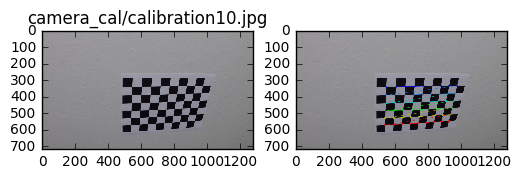

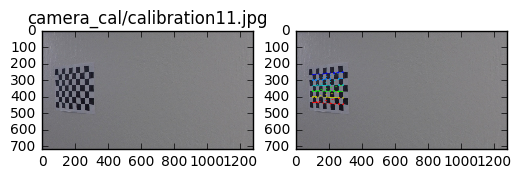

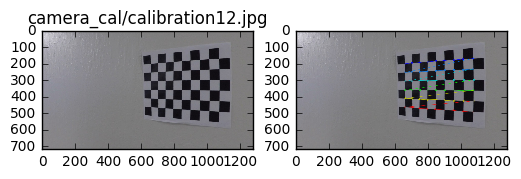

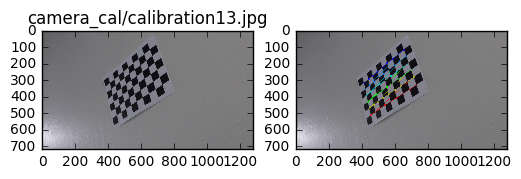

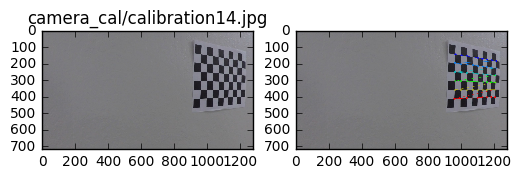

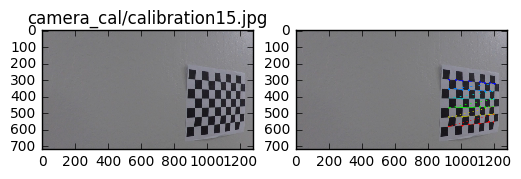

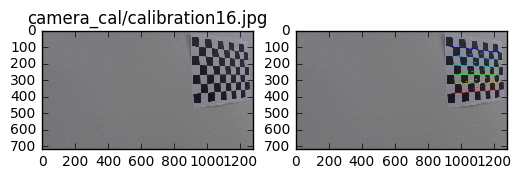

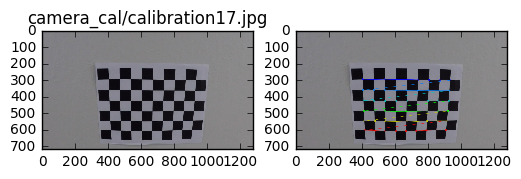

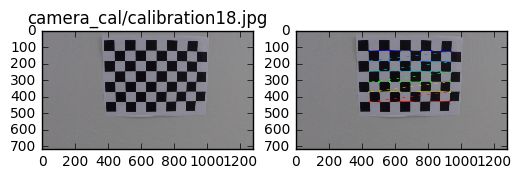

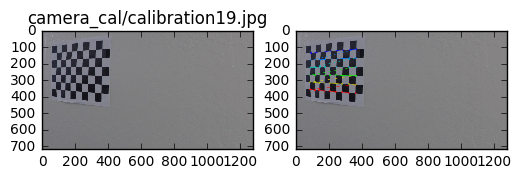

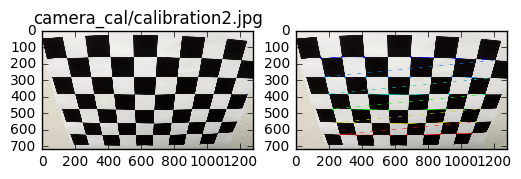

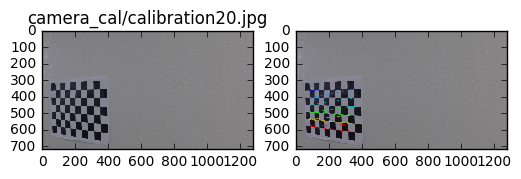

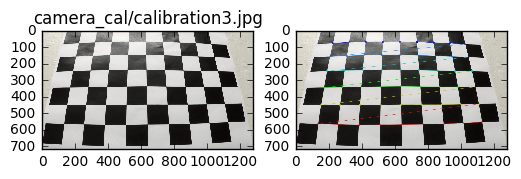

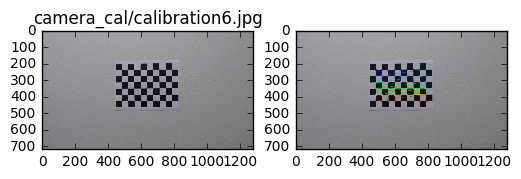

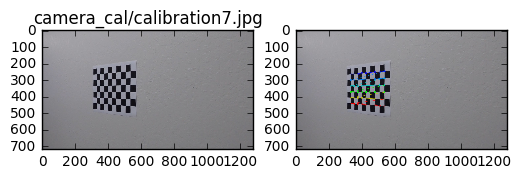

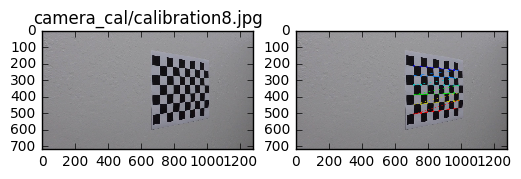

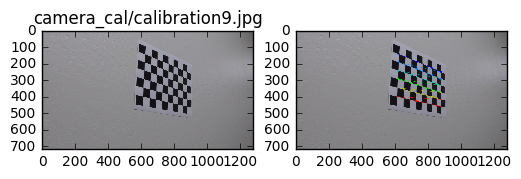

In [2]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

# Prepare object points: (0, 0, 0), (1, 0, 0) ... (7, 5, 0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

image_names = glob.glob("camera_cal/calibration*.jpg")

for image_name in image_names:

    img = mpimg.imread(image_name)
    
    # Find chessboard corners
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny) ,None)

    if ret:
        _, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title(image_name)
        ax1.imshow(img)
        
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ax2.imshow(img)
        plt.show()

With the object and image points, get the camera calibration.

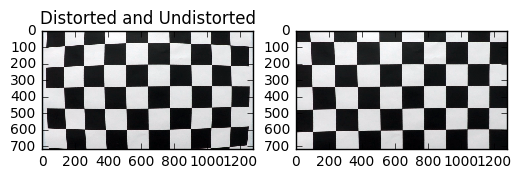

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

"""Function which uses are precalculated distortion matrix values to undistort an image."""
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread("camera_cal/calibration1.jpg")
dst = undistort(img)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Distorted and Undistorted")
ax1.imshow(img)
ax2.imshow(dst)
plt.show()

## Thresholding

Next we want to be able to apply the sobel operator to our images.

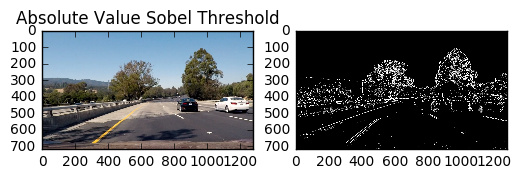

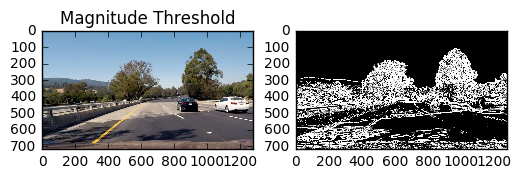

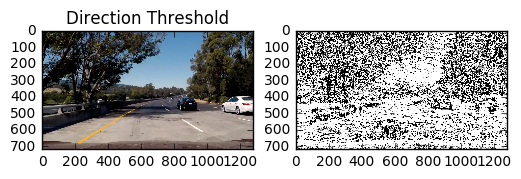

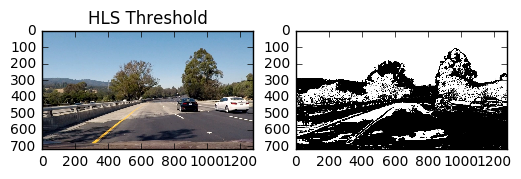

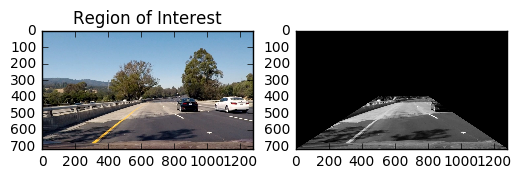

In [4]:
"""Applies the sobel operator on an image"""
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi / 2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    return binary_output

def hls_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def roi(img, verts):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [verts], 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread("test_images/test4.jpg")
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Absolute Value Sobel Threshold")
ax1.imshow(img)    
ax2.imshow(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100), cmap='gray')
plt.show()

img = mpimg.imread("test_images/test4.jpg")
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Magnitude Threshold")
ax1.imshow(img)    
ax2.imshow(mag_thresh(img, mag_thresh=(10, 100)), cmap='gray')
plt.show()

img = mpimg.imread("test_images/test5.jpg")
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Direction Threshold")
ax1.imshow(img)    
ax2.imshow(dir_thresh(img, sobel_kernel=15, dir_thresh=(0.7, 2.0)), cmap='gray')
plt.show()

img = mpimg.imread("test_images/test4.jpg")
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("HLS Threshold")
ax1.imshow(img)    
ax2.imshow(hls_thresh(img, thresh=(50, 150)), cmap='gray')
plt.show()

img = mpimg.imread("test_images/test4.jpg")
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Region of Interest")
ax1.imshow(img)
verts = np.int32([(0, 720), (500, 400), (800, 400), (1280, 720)])
ax2.imshow(roi(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), verts), cmap='gray')
plt.show()

## Perspective Transform

Next we want to apply a perspective transform so that we can get a birds-eye view of the lanes.

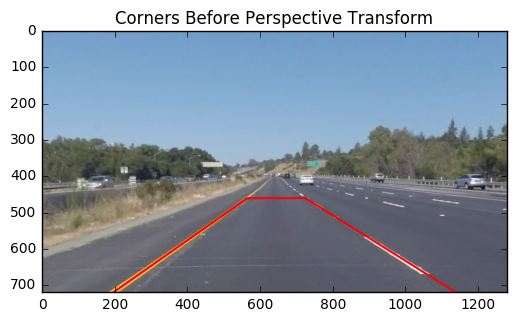

In [5]:
# Load an image with a straight road.
img = mpimg.imread("test_images/solidYellowLeft.jpg")
img = cv2.resize(img, (1280, 720))
img = undistort(img)

def get_src_pts(img):
    top_left = (565, 460)
    top_right = (725, 460)
    bottom_left = (195, 720)
    bottom_right = (1140, 720)
    return (bottom_left, top_left, top_right, bottom_right)

def get_dst_pts(img):
    width = img.shape[1]
    height = img.shape[0]
    top_left = (width*0.1, 0)
    top_right = (width*0.9, 0)
    bottom_left = (width*0.1, height)
    bottom_right = (width*.9, height)
    return (bottom_left, top_left, top_right, bottom_right)
    

path = Path(get_src_pts(img), (Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO))
patch = patches.PathPatch(path, facecolor="none", edgecolor="red", lw=1.5)

fig, ax = plt.subplots(1)
ax.set_title("Corners Before Perspective Transform")
ax.imshow(img)
ax.add_patch(patch)
plt.show()

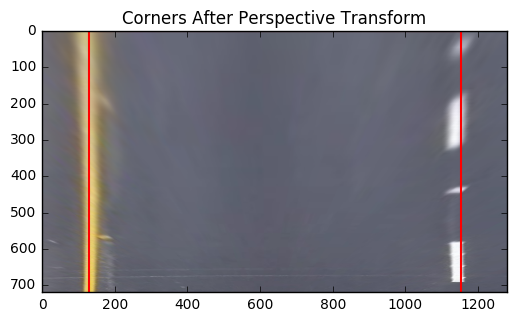

In [6]:
M = cv2.getPerspectiveTransform(np.float32(get_src_pts(img)), np.float32(get_dst_pts(img)))
Minv = cv2.getPerspectiveTransform(np.float32(get_dst_pts(img)), np.float32(get_src_pts(img)))

def warp_perspective(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def unwarp_perspective(img):
    return cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

warped = warp_perspective(img)

path = Path(get_dst_pts(img), (Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO))
patch = patches.PathPatch(path, facecolor="none", edgecolor="red", lw=1.5)

fig, ax = plt.subplots(1)
ax.set_title("Corners After Perspective Transform")
ax.imshow(warped)
ax.add_patch(patch)
plt.show()

## Combining All Preprocessing

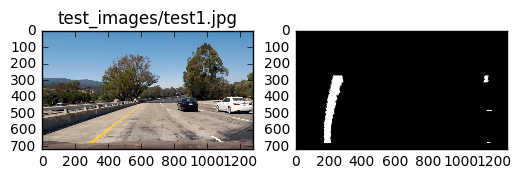

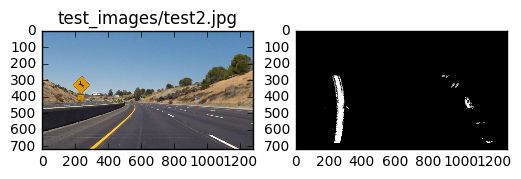

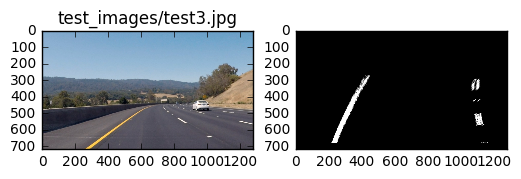

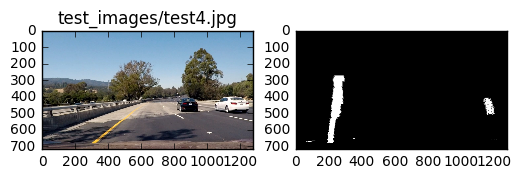

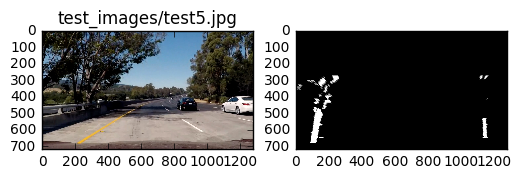

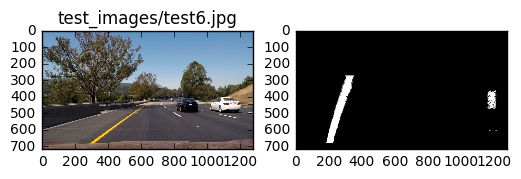

In [7]:
def preprocess(img):
    
    # Undistort
    img = undistort(img)
    
    # Sobel Thresholds
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=255, thresh_max=255)
    mag_binary = mag_thresh(img, mag_thresh=(0, 100))
    dir_binary = dir_thresh(img, sobel_kernel=15, dir_thresh=(0, np.pi*2))
    hls_binary = hls_thresh(img, thresh=(120, 255))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | (hls_binary == 1)] = 1
    
    # Apply ROI
    outer_verts = np.int32([(100, 660), (500, 485), (800, 485), (1135, 660)])
    outer = roi(combined, outer_verts)
    
    inner_verts = np.int32([(400, 720), (580, 500), (750, 500), (1050, 720)])
    inner = roi(combined, inner_verts)
    
    # Warp Perspective
    return warp_perspective((outer-inner).clip(min=0))

image_names = glob.glob("test_images/test*.jpg")
for image_name in image_names:
    img = mpimg.imread(image_name)
    post_img = preprocess(img)

    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title(image_name)
    ax1.imshow(img)
    ax2.imshow(post_img, cmap="gray")
    plt.show()

# Determine Lines

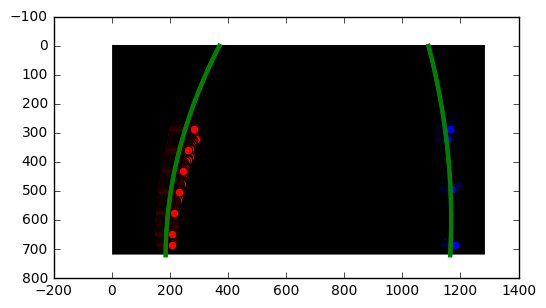

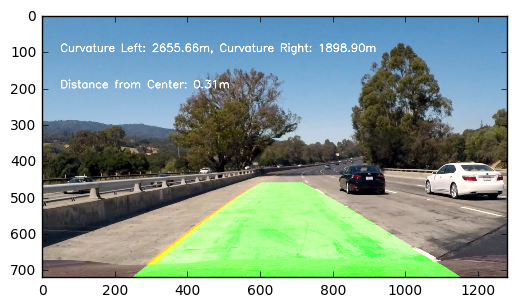

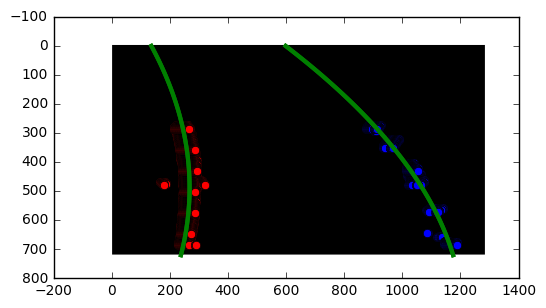

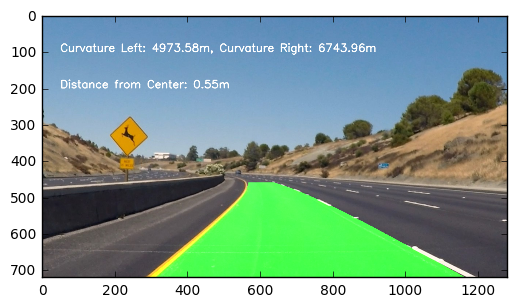

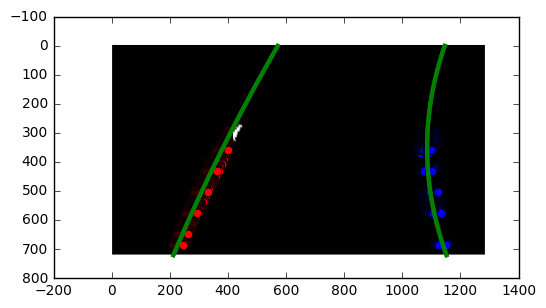

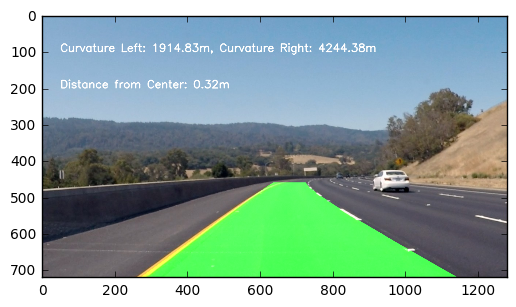

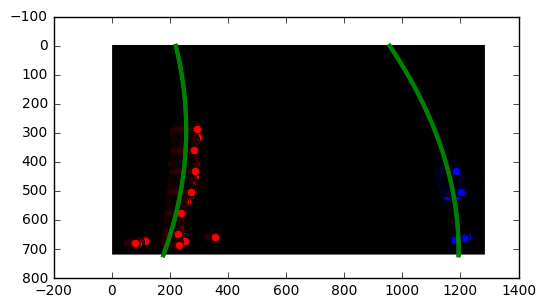

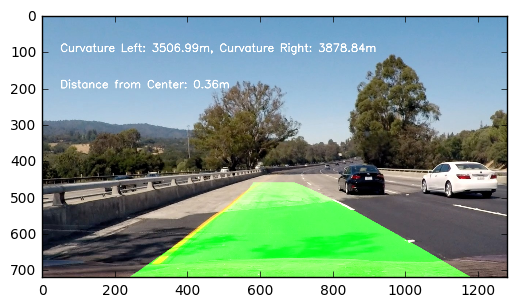

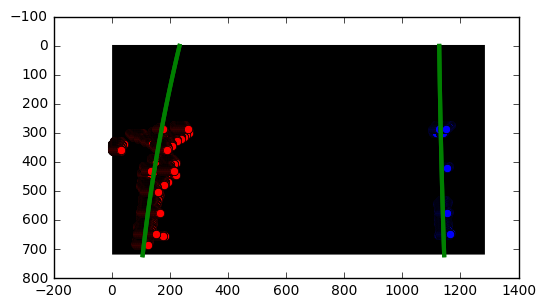

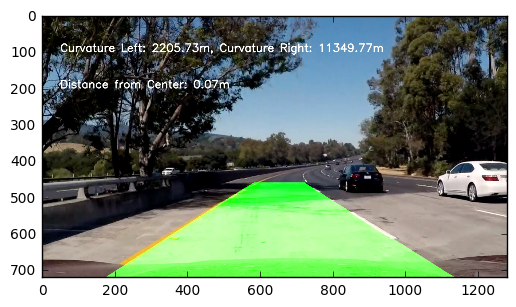

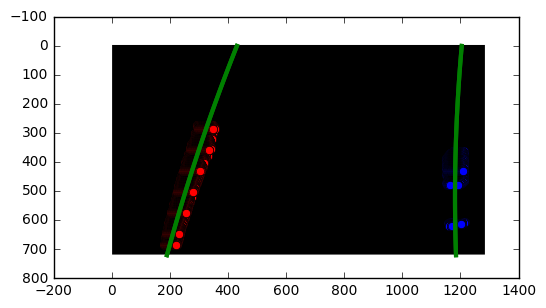

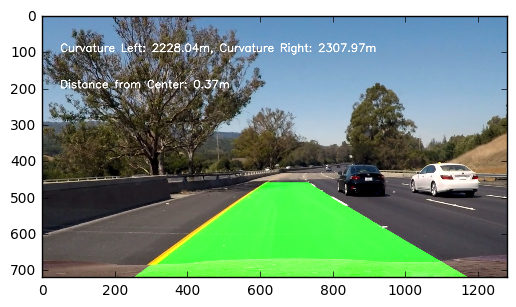

In [94]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def get_lane_pts(img):
    
    window_width = 100
    half_index = (img.shape[1] // 2)
    
    left_half = img[:, 0:half_index]
    right_half = img[:, half_index:]

    left_histogram = np.sum(left_half[left_half.shape[0] / 2:, :], axis=0)
    start_left = np.argmax(left_histogram)

    right_histogram = np.sum(right_half[right_half.shape[0] / 2:, :], axis=0)
    start_right = np.argmax(right_histogram) + half_index

    left_pts = np.zeros(shape=(0, 2))
    right_pts = np.zeros(shape=(0, 2))
    
    window_height = img.shape[0] // num_windows
    
    for i in range(num_windows):
        
        start_y = img.shape[0] - (i * window_height) - window_height
        end_y = start_y + window_height
        image_row = img[start_y:end_y, :]

        next_left = np.transpose(np.where(image_row[:, 0:400] != 0))
        next_left += ((start_y, 0))
        next_right = np.transpose(np.where(image_row[:, 700:1280] != 0))
        next_right += ((start_y, 700))
        
        if len(next_left) > 0:
            left_pts = np.append(left_pts, next_left, axis=0)
            start_left = np.argmax(
                np.sum(image_row[:, start_left-window_width:start_left+window_width], axis=0)) + start_left
        else:
            window_width += 1
        if len(next_right) > 0:
            right_pts = np.append(right_pts, next_right, axis=0)
            start_right = np.argmax(
                np.sum(image_row[:, start_right-window_width:start_right+window_width], axis=0)) + start_right
        else:
            window_width += 1
    return left_pts, right_pts

def get_fit(lane_pts):
    return np.polyfit(lane_pts[:, 0], lane_pts[:, 1], 2)

def get_lane_line(fit):
    yvals = np.linspace(0, 100, num=101) * 7.2
    return fit[0] * yvals ** 2 + fit[1] * yvals + fit[2]

def get_radius_of_curvature(lane_pts):
    yvals = np.linspace(0, 100, num=101) * 7.2
    y_eval = np.max(yvals)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    fit_cr = np.polyfit(yvals*ym_per_pix, lane_pts*xm_per_pix, 2)
    return ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 / np.absolute(2*fit_cr[0])

def get_distance_from_center(img):
    last_row_green = img[img.shape[0] - 1, :, 1]
    lane_pts = np.where(last_row_green > 180)
    if not len(lane_pts) or not len(lane_pts[0]):
        return left_line_meta.line_base_pos
    xm_per_pix = 3.7/700
    center = img.shape[1] / 2
    left_max = lane_pts[0][0]
    right_max = lane_pts[0][-1]
    position = (right_max + left_max) / 2
    left_line_meta.line_base_pos = (position - center) * xm_per_pix
    right_line_meta.line_base_pos = (position - center) * xm_per_pix
    return left_line_meta.line_base_pos
    
def draw_and_unwarp(left_fitx, right_fitx, img, post_img, MInv):
    yvals = np.linspace(0, 100, num=101) * 7.2
    
    left_radius = get_radius_of_curvature(left_fitx)
    right_radius = get_radius_of_curvature(right_fitx)
    if abs((left_radius - right_radius)) / left_radius < 0.3:
        left_line_meta.detected = True
        left_line_meta.recent_xfitted.append(left_fitx)
        right_line_meta.detected = True
        right_line_meta.recent_xfitted.append(right_fitx)
    else:
        if not left_line_meta.recent_xfitted:
            left_line_meta.recent_xfitted.append(left_fitx)
        if not right_line_meta.recent_xfitted:
            right_line_meta.recent_xfitted.append(right_fitx)
    
    left_fitx = np.mean(left_line_meta.recent_xfitted[-5:], axis=0)
    right_fitx = np.mean(right_line_meta.recent_xfitted[-5:], axis=0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(post_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 1, 0)
    
    # Add curvature information
    curvature = "Curvature Left: {}m, Curvature Right: {}m".format(
        "{0:.2f}".format(get_radius_of_curvature(left_fitx)),
        "{0:.2f}".format(get_radius_of_curvature(right_fitx)))
    distance = "Distance from Center: {}m".format(
        "{0:.2f}".format(get_distance_from_center(result)))
    result = cv2.putText(result, curvature, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(result, distance, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return result

"""Using information from the previous frame, determine if this fit makes sense."""
def filter_fit(fit, line_meta):
    if line_meta.current_fit is None:
        line_meta.current_fit = fit
        return fit
    for i, f in enumerate(fit):
        diff = abs((line_meta.current_fit[i] - f) / line_meta.current_fit[i])
        if diff > 500:
            return line_meta.current_fit
    line_meta.current_fit = fit
    return fit
    

def process_image(img):
    post_img = preprocess(img)

    lane_pts = get_lane_pts(post_img)

    left_fit = filter_fit(get_fit(lane_pts[0]), left_line_meta)       
    right_fit = filter_fit(get_fit(lane_pts[1]), right_line_meta)
    
    left_fitx = get_lane_line(left_fit)
    right_fitx = get_lane_line(right_fit)
    return draw_and_unwarp(left_fitx, right_fitx, img, post_img, Minv)

image_names = glob.glob("test_images/test*.jpg")
for image_name in image_names:
    left_line_meta = Line()
    right_line_meta = Line()
    img = mpimg.imread(image_name)
    processed_image = process_image(img)

    plt.imshow(processed_image)
    plt.show()

## Video

In [92]:
left_line_meta = Line()
right_line_meta = Line()
output = 'with_lanes.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image)
%time lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video with_lanes.mp4
[MoviePy] Writing video with_lanes.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<05:17,  3.97it/s]

  0%|          | 2/1261 [00:00<05:13,  4.02it/s]

  0%|          | 3/1261 [00:00<05:09,  4.07it/s]

  0%|          | 4/1261 [00:00<05:17,  3.96it/s]

  0%|          | 5/1261 [00:01<05:12,  4.03it/s]

  0%|          | 6/1261 [00:01<05:03,  4.13it/s]

  1%|          | 7/1261 [00:01<05:12,  4.01it/s]

  1%|          | 8/1261 [00:01<05:04,  4.11it/s]

  1%|          | 9/1261 [00:02<04:57,  4.21it/s]

  1%|          | 10/1261 [00:02<04:56,  4.23it/s]

  1%|          | 11/1261 [00:02<04:51,  4.29it/s]

  1%|          | 12/1261 [00:02<04:48,  4.33it/s]

  1%|          | 13/1261 [00:03<04:48,  4.33it/s]

  1%|          | 14/1261 [00:03<04:45,  4.37it/s]

  1%|          | 15/1261 [00:03<04:46,  4.35it/s]

  1%|▏         | 16/1261 [00:03<04:47,  4.33it/s]

  1%|▏         | 17/1261 [00:04<04:45,  4.36it/s]

  1%|▏         | 18/1261 [00:04<04:44,  4.37it/s]

  2%|▏         | 19/1261 [00:04<04:44,  4.37it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: with_lanes.mp4 

CPU times: user 18min 50s, sys: 1min 50s, total: 20min 40s
Wall time: 4min 56s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))